# 大數據與商業分析 期中專案 第三組
## 用AI及社群數據協助投資決策
資管三 郭子麟 陳沛妤 陳沛竹 莊莊 歐崇愷   
資工四 吳承軒
台科 楊淯潔


附註：Requirement 1 的讀檔檔案都是放在根目錄（皆為老師提供之檔案，除了 stopwords.txt 為網路上檔案，附上繳交）

# Requirement 1

In [ ]:
!pip install monpa

In [ ]:
import csv
import pandas as pd
import numpy as np
import datetime
import monpa
from monpa import utils
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## 讀取股票資訊

In [ ]:
# 設定參數
stock_code = '2330'
stock_name = '台積電'
n = 3

In [ ]:
# 讀取標的股價資訊
path = './stock_data_2019-2021.xlsx'
df19 = pd.read_excel(path, sheet_name = '上市2019', usecols=['證券代碼', '年月日', '收盤價(元)'])
df20 = pd.read_excel(path, sheet_name = '上市2020', usecols=['證券代碼', '年月日', '收盤價(元)'])
df21 = pd.read_excel(path, sheet_name = '上市2021', usecols=['證券代碼', '年月日', '收盤價(元)'])
df19 = df19[df19['證券代碼'] == stock_code + ' ' + stock_name]
df20 = df20[df20['證券代碼'] == stock_code + ' ' + stock_name]
df21 = df21[df21['證券代碼'] == stock_code + ' ' + stock_name]

# 轉換日期格式, sort
df19['年月日'] = pd.to_datetime(df19['年月日']).dt.date
df19 = df19.sort_values(by='年月日')
df19.reset_index(drop=True, inplace=True)

df20['年月日'] = pd.to_datetime(df20['年月日']).dt.date
df20 = df20.sort_values(by='年月日')
df20.reset_index(drop=True, inplace=True)

df21['年月日'] = pd.to_datetime(df21['年月日']).dt.date
df21 = df21.sort_values(by='年月日')
df21.reset_index(drop=True, inplace=True)

# 加入漲跌幅
pct_n = df19['收盤價(元)'] / df19['收盤價(元)'].shift(n) - 1
df19.insert(3, str(n)+'日漲跌幅', pct_n, True)

pct_n = df20['收盤價(元)'] / df20['收盤價(元)'].shift(n) - 1
df20.insert(3, str(n)+'日漲跌幅', pct_n, True)

pct_n = df21['收盤價(元)'] / df21['收盤價(元)'].shift(n) - 1
df21.insert(3, str(n)+'日漲跌幅', pct_n, True)

In [ ]:
def find_sigma(df_fluc):
  pos_cnt = len(df_fluc.loc[df_fluc > 0])
  neg_cnt = len(df_fluc.loc[df_fluc < 0])

  pos_avg = df_fluc.loc[df_fluc > 0].sum() / pos_cnt

  neg_avg = df_fluc.loc[df_fluc < 0].sum() / neg_cnt

  return pos_avg, neg_avg


sigma19_pos, sigma19_neg = find_sigma(df19[str(n)+'日漲跌幅'])
sigma20_pos, sigma20_neg = find_sigma(df20[str(n)+'日漲跌幅'])
sigma21_pos, sigma21_neg = find_sigma(df21[str(n)+'日漲跌幅'])

In [ ]:
# 標記漲跌
conditions19 = [(df19[str(n)+'日漲跌幅'] > sigma19_pos), (df19[str(n)+'日漲跌幅'] < sigma19_neg),
              (df19[str(n)+'日漲跌幅'].between(sigma19_neg, sigma19_pos))]
conditions20 = [(df20[str(n)+'日漲跌幅'] > sigma20_pos), (df20[str(n)+'日漲跌幅'] < sigma20_neg),
              (df20[str(n)+'日漲跌幅'].between(sigma20_neg, sigma20_pos))]
conditions21 = [(df21[str(n)+'日漲跌幅'] > sigma21_pos), (df21[str(n)+'日漲跌幅'] < sigma21_neg),
              (df21[str(n)+'日漲跌幅'].between(sigma21_neg, sigma21_pos))]

values = ['漲', '跌', '-']
df19['label'] = np.select(conditions19, values)
df19['label'][:n] = '-'
df20['label'] = np.select(conditions20, values)
df20['label'][:n] = '-'
df21['label'] = np.select(conditions21, values)
df21['label'][:n] = '-'

# 連接3年資料
price_data = pd.concat([df19, df20, df21])
display(price_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as

,證券代碼,年月日,收盤價(元),3日漲跌幅,label
0,2330 台積電,2019-01-02,202.7032,NaN,-
1,2330 台積電,2019-01-03,199.0093,NaN,-
2,2330 台積電,2019-01-04,192.0832,NaN,-
3,2330 台積電,2019-01-07,196.7006,-0.029613,跌
4,2330 台積電,2019-01-08,194.8536,-0.020882,跌
...,...,...,...,...,...
239,2330 台積電,2021-12-24,604.0000,0.011725,-
240,2330 台積電,2021-12-27,606.0000,0.010000,-
241,2330 台積電,2021-12-28,615.0000,0.014851,-
242,2330 台積電,2021-12-29,616.0000,0.019868,-


In [ ]:
# 確認波動幅度
display(price_data['label'].value_counts())
m = price_data[str(n)+'日漲跌幅'].abs().mean()
print('平均波動:',m)
me = price_data[str(n)+'日漲跌幅'].abs().median()
print('波動中位數:',me)

-    453
漲    156
跌    122
Name: label, dtype: int64

平均波動: 0.021602302874591833
波動中位數: 0.016920508586830363


## 找出 news 檔案中標題或內文有台積電的文章

In [ ]:
news19 = pd.read_csv('./bda2022_mid_news_2019.csv')
news20 = pd.read_csv('./bda2022_mid_news_2020.csv')
news21 = pd.read_csv('./bda2022_mid_news_2021.csv')
news = pd.concat([news19, news20, news21], axis=0).reset_index(drop=True)

news_target = pd.DataFrame(columns=news.columns)
for i in range(news.shape[0]):
  if type(news['title'][i]) != str or type(news['content'][i]) != str: # 可能有nan
    continue
  s = news['title'][i] + news['content'][i]
  if sum(map(s.count, (stock_name, stock_code))) > 3: # 提及標的名稱或代號超過3次
    news_target = pd.concat([news_target, news.iloc[i, :].to_frame().T], axis=0)
news_target = news_target.reset_index(drop=True)

In [ ]:
# 加上漲跌標籤
news_target['post_time'] = pd.to_datetime(news_target['post_time']).dt.date
price_data['年月日-'+str(n)] = price_data['年月日'] - datetime.timedelta(days=n)
news_target = pd.merge(news_target, price_data, left_on='post_time', right_on='年月日-'+str(n))[['post_time', 'title', 'content', 'label']]
news_target= news_target[news_target.label != '-'].reset_index(drop=True)
news_target.head(10)

,post_time,title,content,label
0,2019-01-04,股市要聞：週四(3日)股票市場鉅額交易概況,週四(3日)鉅額交易概況如下：<BR>股 票 代號 數量(張) 價格(元)<BR>統 一 1...,跌
1,2019-01-04,《各報要聞》蘋果自爆雷，概念股全倒,蘋果（AAPL）2019年甫開春自爆調降財測利空，亞洲重量級蘋概股包括台積電、立訊精密、夏普...,跌
2,2019-01-04,《台北股市》外資賣電子，轉進防禦型股票,因大中華需求疲弱、換機潮不如預期，蘋果下修財測，拖累台股蘋概股鴻海、台積電、大立光等股價落難...,跌
3,2019-01-04,1/3證交所鉅額交易日成交資訊,證券代號<BR> 證券名稱<BR> 交易別<BR> 成交價<BR> 成交股數<BR> 成交金...,跌
4,2019-01-04,台股盤前－蘋果自爆+美股遭血洗 台股恐難逃殺機 前低9400點恐難守,國際情勢不穩，本週台股指數表現不佳，昨 (3) 日受蘋果財測利空襲擊，終場跌 61.72 點...,跌
5,2019-01-04,【Y早報】熱錢落跑 權值股重傷,（開盤日09:00出刊）避險情緒導致日圓勁升，美債2年期殖利率低於基準利率；蘋果市值在美企倒...,跌
6,2019-01-04,《外資》賣超股：新光金、台積電、南亞科,經統計，前個交易日(20190103)<BR> 1.外資連續賣超五日以上的股票：<BR> 台...,跌
7,2019-01-04,台積電ADR3日下跌2.16美元跌幅5.91%折台股212.25元,(中央社台北2019年 1月 4日電)台積電在NYSE掛牌 ADR以 34.36美元作收，下...,跌
8,2019-01-04,台股早盤大跌逾百點 失守9400點,（中央社記者張建中台北2019年1月4日電）蘋果(Apple)罕見下修財測，加上美國製造業數...,跌
9,2019-01-04,台積電ADR先破底 股價創18個月低,（中央社記者張建中新竹2019年1月4日電）美國費城半導體指數慘跌5.94%，台積電ADR也...,跌


## 找出 forum 檔案中標題或內文有台積電的文章

In [ ]:
forum19 = pd.read_csv('./bda2022_mid_forum_2019.csv')
forum20 = pd.read_csv('./bda2022_mid_forum_2020.csv')
forum21 = pd.read_csv('./bda2022_mid_forum_2021.csv')
forum = pd.concat([forum19, forum20, forum21], axis=0).reset_index(drop=True)

forum_target = pd.DataFrame(columns=forum.columns)
for i in range(forum.shape[0]):
  if type(forum['title'][i]) != str or type(forum['content'][i]) != str: # 可能有nan
    continue
  s = forum['title'][i] + forum['content'][i]
  if sum(map(s.count, (stock_name, stock_code))) > 3 and len(forum['content'][i]) > 25: # 提及超過3次, 捨棄過短內容
    forum_target = pd.concat([forum_target, forum.iloc[i, :].to_frame().T], axis=0)
forum_target = forum_target.reset_index(drop=True)

In [ ]:
# 加上漲跌標籤
forum_target['post_time'] = pd.to_datetime(forum_target['post_time']).dt.date
forum_target = pd.merge(forum_target, price_data, left_on='post_time', right_on='年月日-'+str(n))[['post_time', 'title', 'content', 'label']]
forum_target = forum_target[forum_target.label != '-'].reset_index(drop=True)
forum_target.head(10)

,post_time,title,content,label
0,2019-01-04,10nm製程以材料的角度來看TSMC贏過三星,<BR>華為麒麟 990 將首發台積電 7 奈米+ 製程，助益台積電<BR>https://...,跌
1,2019-01-08,今天我要是放空大盤，會不會被嘎死啊?,台積電下周四（17日）舉行法說會，外資摩根士丹利向來在會前發布預測，根據大摩預估，台積電本次...,漲
2,2019-02-17,今天我要是放空大盤，會不會被嘎死啊?,中國時報【洪凱音╱台北報導】<BR>台積電日前報廢逾萬片晶圓，現在問題大條了，恐怕衝擊今年全...,漲
3,2019-02-17,台灣首創！台積電將分季發股利 今年預估發9元,民視影音2019年2月17日<BR>下周二就是台積電董事會，會中將討論股利和員工紅利發放事宜...,漲
4,2019-02-18,【香腸幫LDS本部】 ==== 被嘎到外太空之來自星星的S教授!! ====,台灣首創！台積電將分季發股利 今年預估發9元<BR>周二就是台積電董事會，會中將討論股利和員...,漲
5,2019-02-19,高達10萬片！台積廢晶圓 衝擊全球電子鏈,"哀!真的不用三星搞你,自己人就快搞死自己了<BR>~~~~~~~~~~~~~~~~~~~~~...",漲
6,2019-02-19,2409友達 15 元可以追嗎?,台積電董事會還通過修訂公司章程，呈送股東會核准，授權董事會得 每季 決議分派現金股利。待股東...,漲
7,2019-03-16,每次買就大跌每次虧上萬賣後就噴漲 研究了兩年想到個方法降低買股虧損機率和金額這方法可行嗎?,如題<BR>最近兩年<BR>基本上2017年開始<BR>我每次買股票買後不久就大跌<BR>平...,漲
8,2019-03-19,論，戰神重返，強勢進攻美股,台股加權指數呈現水泥、紡織類股表現穩健，台泥 (1101) 、亞泥 (1102) 分別上漲 ...,漲
9,2019-03-24,論，股市不敗戰神，絕對賺錢法。,本周最重要的大事件莫過於聯準會利率決策會議，會議結果比市場想像更為鴿派，不但幾乎確定全年恐無...,跌


## 找出 bbs 檔案中標題或內文有台積電的文章

In [ ]:
bbs = pd.read_csv('./bda2022_mid_bbs_2019-2021.csv')

bbs_target = pd.DataFrame(columns=bbs.columns)
for i in range(bbs.shape[0]):
  if any(title_class in bbs['title'][i] for title_class in ['[標的]', '[新聞]', '[情報]']):  # 取部分標題分類
    if type(bbs['title'][i]) != str or type(bbs['content'][i]) != str: #可能有nan:
      continue
    s = bbs['title'][i] + bbs['content'][i]
    if sum(map(s.count, (stock_name, stock_code))) > 3: # 提及超過3次
      bbs_target = pd.concat([bbs_target, bbs.iloc[i, :].to_frame().T], axis=0)
bbs_target = bbs_target.reset_index(drop=True)

In [ ]:
# 加上漲跌標籤
bbs_target['post_time'] = pd.to_datetime(bbs_target['post_time']).dt.date
bbs_target = pd.merge(bbs_target, price_data, left_on='post_time', right_on='年月日-'+str(n))[['post_time', 'title', 'content', 'label']]
bbs_target = bbs_target[bbs_target.label != '-'].reset_index(drop=True)
bbs_target.head(10)

,post_time,title,content,label
0,2019-01-04,[標的] 2330 台積電 長期空 下看110!,1. 標的：2330 台積電 2. 分類：長期空 3. 分析/正文： (1)年線| K...,跌
1,2019-01-12,[新聞] 外資：台積將演利空出盡行情,1.原文連結： https://money.udn.com/money/story/5607...,漲
2,2019-01-12,Re: [新聞] 離岸風電真相：銀行須負擔約八千多億無擔,這一系列文讓我想到 當初張忠謀先生想回台發展晶圓代工 台灣一系列的只支持聯電 不支援...,漲
3,2019-01-25,[新聞] 賽靈思展望佳 台系供應鏈台積電、先豐有,-------------------------------發文提醒-----------...,漲
4,2019-01-27,[新聞] 社會只關心選舉，讓台積電張淑芬又氣又急,1.原文連結： https://reurl.cc/58MD7 2.原文內容： 社會只關心選...,跌
5,2019-02-10,[新聞] 台積 拚季季配息,1.原文連結： https://money.udn.com/money/story/5607...,漲
6,2019-02-17,[新聞] 台積電擴廠用地 居民公聽會舉白布條抗議,1.原文連結： https://money.udn.com/money/story/561...,漲
7,2019-02-17,[新聞] 台積電元宵節發大紅包 將創現金股息總額最高等3項第1,1.原文連結： https://tw.finance.appledaily.com/rea...,漲
8,2019-02-18,[新聞] 台積電 吃下10萬片報廢晶圓,1.原文連結： https://udn.com/news/story/7240/364938...,漲
9,2019-02-18,[新聞] 檢測更嚴 台積電交貨期恐拉長,1.原文連結： https://money.udn.com/money/story/561...,漲


## 斷詞

In [ ]:
# 將字串以正則化處理去除中文字元以外的字元
def clearSentence(sentence):
  return re.sub(r'[^\u4e00-\u9fa5]+', '', sentence)

# 匯入繁體中文停用詞
path = './stopwords.txt'
with open(path, 'r') as file:
  stopwords = file.read().splitlines()
file.close()

path = './stopwords_zh.txt'
with open(path, 'r') as file:
  stopwords_zh = file.read().splitlines()
file.close()

stopwords = list(set.union(set(stopwords), set(stopwords_zh)))

In [ ]:
def cutTerm(articles, start_date, end_date):
  tokenStr_list = []
  for i in list(articles[articles['post_time'].between(start_date, end_date)].index):
    if i % 100 == 0 and i != 0:
      print('已處理 {} 篇文章'.format(i))
    query = articles['title'][i] + articles['content'][i]
    try:
      sentence_list = utils.short_sentence(query) # 斷句
      tokenStr = str()
      for sentence in sentence_list:
        sentence = clearSentence(sentence) # 留下中文
        tokens = monpa.cut(sentence) # 斷詞
        tokens = [token for token in tokens if len(token) > 1] # 去掉長度為1的詞
        tokenStr += ' '.join(tokens)
      tokenStr_list.append(tokenStr)
    except:
      tokenStr_list.append('')

  return tokenStr_list

In [ ]:
# 設定訓練資料集的開始日期與結束日期
train_startDate = datetime.date(2019,1,1)
train_endDate = datetime.date(2021,12,31)

news_tokenStr_list = cutTerm(news_target, train_startDate, train_endDate)
forum_tokenStr_list = cutTerm(forum_target, train_startDate, train_endDate)
bbs_tokenStr_list = cutTerm(bbs_target, train_startDate, train_endDate)
train_tokenStr_list = news_tokenStr_list + forum_tokenStr_list + bbs_tokenStr_list

/usr/local/lib/python3.7/dist-packages/monpa/crf_layer.py:374: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


已處理 100 篇文章
已處理 200 篇文章
已處理 300 篇文章
已處理 400 篇文章
已處理 500 篇文章
已處理 600 篇文章
已處理 700 篇文章
已處理 800 篇文章
已處理 900 篇文章
已處理 1000 篇文章
已處理 1100 篇文章
已處理 1200 篇文章
已處理 1300 篇文章
已處理 1400 篇文章
已處理 1500 篇文章
已處理 1600 篇文章
已處理 1700 篇文章
已處理 1800 篇文章
已處理 1900 篇文章
已處理 2000 篇文章
已處理 2100 篇文章
已處理 2200 篇文章
已處理 2300 篇文章
已處理 2400 篇文章
已處理 100 篇文章
已處理 200 篇文章
已處理 300 篇文章
已處理 400 篇文章
已處理 500 篇文章
已處理 100 篇文章
已處理 200 篇文章
已處理 300 篇文章
已處理 400 篇文章
已處理 500 篇文章
已處理 600 篇文章
已處理 700 篇文章
已處理 800 篇文章


## 建立空間向量

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(train_tokenStr_list)
X = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
X

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,一一一九四,一一九五,一一五,一一四,一一四五,一七一九,一七七九,一七七億,一七二九,一七八六一一,...,龍騰,龐大,龐大不過,龐大家登,龐大統計,龐氏,龐然,龔中原,龔明鑫,龜毛
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_news = news_target[news_target['post_time'].between(train_startDate, train_endDate)]['label']
y_forum = forum_target[forum_target['post_time'].between(train_startDate, train_endDate)]['label']
y_bbs = bbs_target[bbs_target['post_time'].between(train_startDate, train_endDate)]['label']
y = pd.concat([y_news, y_forum, y_bbs], ignore_index=True)
y.to_csv("raw_y.csv")

chi2_selector = SelectKBest(chi2, k = 500)
chi2_selector.fit(X, y)
kbest_vocabs = X.columns[chi2_selector.get_support()]
X = X[kbest_vocabs]
X

,七八,上任,上半年,上漲,下半年,下周,下挫,下跌,下跌元,下達,...,高標,高燦鳴,高盛證券,高雄廠,鬆綁,鴻海研究院,黃仁昭,黃文清,齊揚,龍巖
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.278707,0.000000,0.000000,0.0,0.170808,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.030843,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3878,0.0,0.0,0.031721,0.000000,0.027914,0.045896,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3879,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3880,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA

In [ ]:
from sklearn.decomposition import PCA
print(X.shape)
pca = PCA(n_components=150, copy=True, whiten=False)
pca_x = pca.fit_transform(X)
X = pd.DataFrame(pca_x)
print(X.shape)

(3882, 500)
(3882, 150)


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.053760,-0.055461,-0.013648,-0.008394,-0.045548,0.071730,0.040976,0.001507,0.004343,0.015416,...,0.000550,0.013712,0.000039,0.005557,-0.013331,0.008754,0.007145,0.015894,0.005278,-0.001955
1,0.063740,0.008183,-0.020602,0.110663,-0.016013,0.013510,-0.112066,0.135551,0.039627,0.052619,...,-0.011066,0.011094,-0.011314,-0.013648,-0.012312,-0.012493,-0.004495,0.001211,0.009296,-0.008296
2,0.096409,-0.063560,-0.028101,-0.004981,-0.049728,-0.002479,-0.039967,-0.011785,-0.057990,-0.057820,...,-0.004452,0.003513,0.005736,0.000400,0.015040,-0.011128,-0.004212,-0.005176,0.013924,0.008186
3,-0.080678,-0.173637,0.155992,0.016279,-0.094409,0.338130,0.311175,0.162589,0.030212,0.248971,...,0.000598,0.003374,0.000005,-0.001038,-0.002624,0.001218,-0.001771,0.002334,-0.000754,-0.000273
4,-0.022760,-0.025821,-0.034582,0.055073,-0.023851,-0.009953,-0.033473,0.023947,-0.010051,-0.008930,...,-0.016755,0.010253,0.013146,0.008366,0.012306,0.004649,0.004827,-0.001950,0.009775,0.014545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,-0.037217,-0.029633,-0.025784,0.009974,-0.021912,0.009600,-0.038694,0.009196,0.014954,0.021169,...,0.009120,0.004453,0.001530,0.007005,-0.001994,0.001158,-0.004155,0.008106,-0.002088,-0.004341
3878,-0.014206,-0.023919,-0.036870,0.002097,0.058858,-0.004888,0.014894,-0.004314,-0.010836,-0.009205,...,0.008430,-0.004777,-0.001195,0.001554,-0.000323,-0.001072,0.005123,0.004626,-0.003186,-0.004540
3879,-0.041651,0.039115,0.010841,-0.006464,-0.026530,0.003732,-0.000209,-0.040708,-0.025637,-0.004446,...,-0.015602,-0.053321,-0.020702,0.133337,0.019053,0.115975,0.030204,0.010835,0.015367,0.009218
3880,-0.045310,-0.030849,-0.024083,-0.008172,-0.020831,0.006907,-0.013706,-0.033130,0.000111,0.007540,...,0.002480,-0.010945,-0.007015,0.009764,-0.006530,-0.001841,0.004370,-0.007518,-0.000500,0.000612


In [ ]:
post_time_list = news = pd.concat([news_target['post_time'], forum_target['post_time'], bbs_target['post_time']], axis=0).reset_index(drop=True)
#post_time_list
X['post_time'] = post_time_list
X.to_csv("raw_x.csv")
X

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,post_time
0,-0.053760,-0.055461,-0.013648,-0.008394,-0.045548,0.071730,0.040976,0.001507,0.004343,0.015416,...,0.013712,0.000039,0.005557,-0.013331,0.008754,0.007145,0.015894,0.005278,-0.001955,2019-01-04
1,0.063740,0.008183,-0.020602,0.110663,-0.016013,0.013510,-0.112066,0.135551,0.039627,0.052619,...,0.011094,-0.011314,-0.013648,-0.012312,-0.012493,-0.004495,0.001211,0.009296,-0.008296,2019-01-04
2,0.096409,-0.063560,-0.028101,-0.004981,-0.049728,-0.002479,-0.039967,-0.011785,-0.057990,-0.057820,...,0.003513,0.005736,0.000400,0.015040,-0.011128,-0.004212,-0.005176,0.013924,0.008186,2019-01-04
3,-0.080678,-0.173637,0.155992,0.016279,-0.094409,0.338130,0.311175,0.162589,0.030212,0.248971,...,0.003374,0.000005,-0.001038,-0.002624,0.001218,-0.001771,0.002334,-0.000754,-0.000273,2019-01-04
4,-0.022760,-0.025821,-0.034582,0.055073,-0.023851,-0.009953,-0.033473,0.023947,-0.010051,-0.008930,...,0.010253,0.013146,0.008366,0.012306,0.004649,0.004827,-0.001950,0.009775,0.014545,2019-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,-0.037217,-0.029633,-0.025784,0.009974,-0.021912,0.009600,-0.038694,0.009196,0.014954,0.021169,...,0.004453,0.001530,0.007005,-0.001994,0.001158,-0.004155,0.008106,-0.002088,-0.004341,2021-11-22
3878,-0.014206,-0.023919,-0.036870,0.002097,0.058858,-0.004888,0.014894,-0.004314,-0.010836,-0.009205,...,-0.004777,-0.001195,0.001554,-0.000323,-0.001072,0.005123,0.004626,-0.003186,-0.004540,2021-11-22
3879,-0.041651,0.039115,0.010841,-0.006464,-0.026530,0.003732,-0.000209,-0.040708,-0.025637,-0.004446,...,-0.053321,-0.020702,0.133337,0.019053,0.115975,0.030204,0.010835,0.015367,0.009218,2021-11-22
3880,-0.045310,-0.030849,-0.024083,-0.008172,-0.020831,0.006907,-0.013706,-0.033130,0.000111,0.007540,...,-0.010945,-0.007015,0.009764,-0.006530,-0.001841,0.004370,-0.007518,-0.000500,0.000612,2021-11-22


# Requirement 2

## 處理欄位並切分 train, test data

In [ ]:
X = X.drop('post_time',axis=1)  #因為是刪除「欄位」，所以設定axis=1
X = X.drop('Unnamed: 0',axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.053760,-0.055461,-0.013648,-0.008394,-0.045548,0.071730,0.040976,0.001507,0.004343,0.015416,...,0.000550,0.013712,0.000039,0.005557,-0.013331,0.008754,0.007145,0.015894,0.005278,-0.001955
1,0.063740,0.008183,-0.020602,0.110663,-0.016013,0.013510,-0.112066,0.135551,0.039627,0.052619,...,-0.011066,0.011094,-0.011314,-0.013648,-0.012312,-0.012493,-0.004495,0.001211,0.009296,-0.008296
2,0.096409,-0.063560,-0.028101,-0.004981,-0.049728,-0.002479,-0.039967,-0.011785,-0.057990,-0.057820,...,-0.004452,0.003513,0.005736,0.000400,0.015040,-0.011128,-0.004212,-0.005176,0.013924,0.008186
3,-0.080678,-0.173637,0.155992,0.016279,-0.094409,0.338130,0.311175,0.162589,0.030212,0.248971,...,0.000598,0.003374,0.000005,-0.001038,-0.002624,0.001218,-0.001771,0.002334,-0.000754,-0.000273
4,-0.022760,-0.025821,-0.034582,0.055073,-0.023851,-0.009953,-0.033473,0.023947,-0.010051,-0.008930,...,-0.016755,0.010253,0.013146,0.008366,0.012306,0.004649,0.004827,-0.001950,0.009775,0.014545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,-0.037217,-0.029633,-0.025784,0.009974,-0.021912,0.009600,-0.038694,0.009196,0.014954,0.021169,...,0.009120,0.004453,0.001530,0.007005,-0.001994,0.001158,-0.004155,0.008106,-0.002088,-0.004341
3878,-0.014206,-0.023919,-0.036870,0.002097,0.058858,-0.004888,0.014894,-0.004314,-0.010836,-0.009205,...,0.008430,-0.004777,-0.001195,0.001554,-0.000323,-0.001072,0.005123,0.004626,-0.003186,-0.004540
3879,-0.041651,0.039115,0.010841,-0.006464,-0.026530,0.003732,-0.000209,-0.040708,-0.025637,-0.004446,...,-0.015602,-0.053321,-0.020702,0.133337,0.019053,0.115975,0.030204,0.010835,0.015367,0.009218
3880,-0.045310,-0.030849,-0.024083,-0.008172,-0.020831,0.006907,-0.013706,-0.033130,0.000111,0.007540,...,0.002480,-0.010945,-0.007015,0.009764,-0.006530,-0.001841,0.004370,-0.007518,-0.000500,0.000612


In [ ]:
y = y.drop('Unnamed: 0',axis=1)  
y

,label
0,跌
1,跌
2,跌
3,跌
4,跌
...,...
3877,跌
3878,跌
3879,跌
3880,跌


In [ ]:
# 以下將自身資料切成train及test兩組，重新訓練一次，測試模型準確率
# 承接 requirement 1 - train_test_split的參數 X, y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) #隨機挑選20%當測試資料

## Precision Measuring

In [ ]:
#y_test和y_pred 當參數，計算準確率以及印出分類報告和混淆矩陣
def Score(y_test, y_pred):
    from sklearn import metrics 
    from sklearn.metrics import accuracy_score
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #比對答案，計算準確率

    from sklearn.metrics import classification_report  
    print(classification_report(y_test, y_pred)) #印出分類報告

    from sklearn.metrics import confusion_matrix  
    print(confusion_matrix(y_test, y_pred, labels=['漲','跌'])) #印出混淆矩陣
    
    from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
    weightedAverageRate = precision_score(y_test, y_pred, average='weighted')
    print("Weighted precision:", weightedAverageRate)
    return weightedAverageRate

In [ ]:
#y_test和y_pred 當參數，回傳 weighted avg
def SimpleScore(y_test, y_pred):
    from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
    weightedAverageRate = precision_score(y_test, y_pred, average='weighted')
    return weightedAverageRate

## NB

In [ ]:
def NB(X_train,X_test,y_train,y_test):
  from sklearn.naive_bayes import GaussianNB
  classifier = GaussianNB()
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測

  weightedAverageRate = Score(y_test, y_pred)
  return weightedAverageRate

## DT

### entropy (Information Gain)

In [ ]:
def DTEntropy(X_train,X_test,y_train,y_test) :
  from sklearn.tree import DecisionTreeClassifier                          
  classifier = DecisionTreeClassifier(criterion="entropy")
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測

  weightedAverageRate = Score(y_test, y_pred)
  return weightedAverageRate

### gini

In [ ]:
def DTGINI(X_train,X_test,y_train,y_test) :
  from sklearn.tree import DecisionTreeClassifier                          
  classifier = DecisionTreeClassifier(criterion="gini")
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測

  weightedAverageRate = Score(y_test, y_pred)
  return weightedAverageRate

## SVM

### linear

In [ ]:
def SVM_LINEAR(X_train,X_test,y_train,y_test) :
  from sklearn.svm import SVC
  classifier = SVC(kernel='linear')
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測

  weightedAverageRate = Score(y_test, y_pred)
  return weightedAverageRate

### rbf

In [ ]:
def SVM_RBF(X_train,X_test,y_train,y_test) :
  from sklearn.svm import SVC
  classifier = SVC(kernel='rbf')
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測
  
  weightedAverageRate = Score(y_test, y_pred)
  return weightedAverageRate

## KNN

### 先以 neighbor number 為 i 做計算 當函式參數

In [ ]:
def KNN(X_train,X_test,y_train,y_test,i) :
  from sklearn.neighbors import KNeighborsClassifier
  classifier = KNeighborsClassifier(n_neighbors=i)
  classifier.fit(X_train, y_train) #訓練
  y_pred = classifier.predict(X_test) #用測試資料預測

  weightedAverageRate = SimpleScore(y_test, y_pred)
  return weightedAverageRate

### 計算 neighbor number = ? weighted average precision 最大

In [ ]:
def MaxKNN (X_train,X_test,y_train,y_test):
    number = [] #X list neighbor number 
    result = [] #y list weightedAverageRate
    rateKNN = {} # weighteAverageRate of KNN 
    
    for i in range(1,15): #預設1-15
        number.append(i)
        weightedAverageRate = KNN(X_train,X_test,y_train,y_test,i)
        rateKNN[i] = weightedAverageRate
        result.append(weightedAverageRate)
    max_key = max(rateKNN, key=lambda key: rateKNN[key]) #max KNN weighteAverageRate 最大值
    print("best neighbor number:", max_key)
    print("Weighted precision:", rateKNN[max_key])
    from matplotlib import pyplot as plt #畫weighted avg 圖
    %matplotlib inline
    plt.rcParams["figure.dpi"] = 80
    plt.plot(number,result)
    plt.title("KNN's weighted precision vs neighbors number") # title
    plt.ylabel("weighted precision") # y label
    plt.xlabel("neighbors number") # x label
  
    return max_key, rateKNN[max_key]

## 跑全部模型函式

In [ ]:
predict={} #存每個演算法的名字及Weighted Average Precision
def modelPredict(X_train,X_test,y_train,y_test):
    print("-------------------------------NB-------------------------------------")
    WARate_NB = NB(X_train,X_test,y_train,y_test)
    predict['NB'] = WARate_NB
    print("-------------------------------DTEntropy------------------------------------")
    WARate_DTEntropy = DTEntropy(X_train,X_test,y_train,y_test)
    predict['DTEntropy'] =  WARate_DTEntropy
    print("--------------------------------DTGINI------------------------------------")
    WARate_DTGINI = DTGINI(X_train,X_test,y_train,y_test)
    predict['DTGINI'] = WARate_DTGINI
    print("---------------------------------SVM_LINEAR-----------------------------------")
    WARate_SVM_LINEAR = SVM_LINEAR(X_train,X_test,y_train,y_test)
    predict['SVM_LINEAR'] = WARate_SVM_LINEAR
    print("---------------------------------SVM_RBF--------------------------------")
    WARate_SVM_RBF = SVM_RBF(X_train,X_test,y_train,y_test)
    predict['SVM_RBF'] = WARate_SVM_RBF
    print("------------------------------------KNN--------------------------------")
    numNeighbor, WARate_KNN= MaxKNN (X_train,X_test,y_train,y_test) 
    predict['KNN'] = WARate_KNN
    
    print("------------------------------------final result--------------------------------")
    print(predict)
    #MAX 字典最大prediction
    max_key = max(predict, key=lambda key: predict[key])
    if  max_key == "KNN" :
        print("適合用：{0}, number of neighbors: {1}, weighted precision: {2}".format(max_key,numNeighbor,predict[max_key]))  
    else:
        print("適合用：{0}, weighted precision: {1}".format(max_key,predict[max_key]))  
    

## INPUT (X_train, X_test, y_train, y_test 當參數)

-------------------------------NB-------------------------------------
Accuracy: 0.6190476190476191
              precision    recall  f1-score   support

           漲       0.66      0.59      0.62       414
           跌       0.58      0.65      0.61       363

    accuracy                           0.62       777
   macro avg       0.62      0.62      0.62       777
weighted avg       0.62      0.62      0.62       777

[[246 168]
 [128 235]]
Weighted precision: 0.6228894445213231
-------------------------------DTEntropy------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5701415701415702
              precision    recall  f1-score   support

           漲       0.61      0.55      0.58       414
           跌       0.54      0.60      0.56       363

    accuracy                           0.57       777
   macro avg       0.57      0.57      0.57       777
weighted avg       0.57      0.57      0.57       777

[[227 187]
 [147 216]]
Weighted precision: 0.5737951980836231
--------------------------------DTGINI------------------------------------
Accuracy: 0.5701415701415702
              precision    recall  f1-score   support

           漲       0.61      0.55      0.58       414
           跌       0.54      0.60      0.57       363

    accuracy                           0.57       777
   macro avg       0.57      0.57      0.57       777
weighted avg       0.57      0.57      0.57       777

[[226 188]
 [146 217]]
Weighted precision: 0.5740185654164149
---------------------------------SVM_LINEAR-----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6653796653796654
              precision    recall  f1-score   support

           漲       0.74      0.58      0.65       414
           跌       0.61      0.77      0.68       363

    accuracy                           0.67       777
   macro avg       0.68      0.67      0.66       777
weighted avg       0.68      0.67      0.66       777

[[239 175]
 [ 85 278]]
Weighted precision: 0.6797388684805903
---------------------------------SVM_RBF--------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.694980694980695
              precision    recall  f1-score   support

           漲       0.75      0.64      0.69       414
           跌       0.65      0.75      0.70       363

    accuracy                           0.69       777
   macro avg       0.70      0.70      0.69       777
weighted avg       0.70      0.69      0.69       777

[[267 147]
 [ 90 273]]
Weighted precision: 0.7021624866162681
------------------------------------KNN--------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

best neighbor number: 2
Weighted precision: 0.6351826670769402
------------------------------------final result--------------------------------
{'NB': 0.6228894445213231, 'DTEntropy': 0.5737951980836231, 'DTGINI': 0.5740185654164149, 'SVM_LINEAR': 0.6797388684805903, 'SVM_RBF': 0.7021624866162681, 'KNN': 0.6351826670769402}
適合用：SVM_RBF, weighted precision: 0.7021624866162681


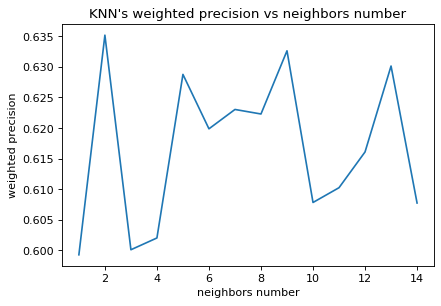

In [ ]:
modelPredict(X_train,X_test,y_train,y_test)

# Requirement 3

## 移動回測

### 讀檔及 sort by date

以下程式碼將讀取 requirement 1 產出的向量空間：raw_x.csv，並依照 post_time 排序，請確認 raw_x.csv 包含 post_time 及 label

In [ ]:
!pip install gdown

In [ ]:
import gdown

url = "https://drive.google.com/u/0/uc?id=1XpB_0RRB-r-IfZqxfGoylbJnsTtNQfSE&export=download"
output = 'raw_x.csv'
gdown.download(url, output)

url = "https://drive.google.com/u/0/uc?id=1y0H6XLBToGwWpP1rAYL31qYpmSTbzorS&export=download"
output = 'raw_y.csv'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/0/uc?id=1XpB_0RRB-r-IfZqxfGoylbJnsTtNQfSE&export=download
To: /content/raw_x.csv
100%|██████████| 12.6M/12.6M [00:00<00:00, 238MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1y0H6XLBToGwWpP1rAYL31qYpmSTbzorS&export=download
To: /content/raw_y.csv
100%|██████████| 33.8k/33.8k [00:00<00:00, 34.1MB/s]


'raw_y.csv'

In [ ]:
import pandas as pd
import numpy as np
X_train = pd.read_csv('raw_x.csv', header=None)

X_train = X_train.drop([0], axis=1)

X_train.columns = X_train.iloc[0]
X_train = X_train.drop([0], axis=0)

data_root='./'
y_train = pd.read_csv(data_root + 'raw_y.csv', header=None) 
def replace_label(y):

  temp = np.array(y[1])

  temp[temp=='漲']=1
  temp[temp=='跌']=0
  return temp[1:]
y_train = replace_label(y_train)
X_train['label'] = y_train

X_train = X_train.sort_values(by=['post_time'])

display(X_train.head())
display(X_train.tail())

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,post_time,label
1,-0.053760,-0.055461,-0.013648,-0.008394,-0.045548,0.071730,0.040976,0.001507,0.004343,0.015416,...,0.000039,0.005557,-0.013331,0.008754,0.007145,0.015894,0.005278,-0.001955,2019-01-04,0
2997,-0.045915,-0.034948,-0.025331,-0.009326,-0.024371,0.008077,-0.014458,-0.031986,0.001422,0.005842,...,-0.001522,0.001389,0.001217,0.001195,0.000367,0.000399,-0.000768,-0.002377,2019-01-04,0
2449,-0.032694,-0.031651,-0.027993,-0.006008,-0.007848,-0.001451,-0.001871,-0.031269,0.008103,0.037569,...,0.001150,0.005948,0.003571,-0.007360,0.004505,0.006682,0.002113,-0.001997,2019-01-04,0
17,-0.034349,-0.025754,-0.022688,0.002801,-0.027429,0.011771,-0.041624,0.014321,0.005889,0.011594,...,-0.006814,-0.012666,0.003735,-0.006727,0.011757,-0.009043,-0.007050,-0.015420,2019-01-04,0
16,0.008971,-0.014802,-0.028270,0.077235,-0.025922,-0.016629,-0.003174,-0.004897,-0.028547,-0.019143,...,0.008675,0.003985,-0.004281,-0.005707,-0.004889,0.005889,0.006518,0.008895,2019-01-04,0


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,post_time,label
2444,-0.046535,-0.043356,-0.052422,-0.013869,0.019119,-0.072464,0.060289,-0.004776,-0.014356,0.168705,...,-0.000792,-0.004321,0.006082,0.011671,-0.003559,-0.010208,-0.005521,0.002082,2021-11-23,0
2445,-0.036406,0.097738,0.039497,-0.001178,-0.023801,0.002289,0.012070,-0.027079,-0.035074,0.021847,...,0.013395,-0.014585,0.010287,-0.003285,0.007224,0.001661,0.004232,0.001110,2021-11-29,1
2446,-0.041912,0.010677,-0.006959,-0.005735,-0.010288,-0.011487,0.010532,-0.022493,-0.001687,-0.003096,...,0.002613,0.003707,0.004570,-0.004355,-0.000002,-0.000041,-0.002125,0.000203,2021-11-29,1
2447,0.063873,-0.041102,-0.035911,0.086065,-0.037191,-0.000884,-0.035985,0.009880,-0.029769,-0.033564,...,0.024602,-0.041901,0.014702,0.015693,-0.021553,0.012056,-0.041882,-0.012148,2021-11-29,1
2448,-0.039624,-0.029982,-0.022689,-0.007692,-0.021584,0.005038,-0.011954,-0.028640,0.000969,0.003922,...,0.008631,0.007466,0.000448,0.010610,-0.004579,0.003107,-0.001303,0.004257,2021-11-29,1


### 定義移動回測的資料集切割函數
此函數可傳入不同 window size (也就是想要用前幾個月預測下個月)，並切分訓練及測試集 

In [ ]:
def set_month_window(size):
  periods = 36 - size
  sizeStr = ''
  if size < 10: sizeStr = '0' + str(size)
  else: sizeStr = str(size)

  start_dates = pd.date_range(start='2018-12', periods=periods, freq='M')
  start_dates = start_dates.format(formatter = lambda x: x.strftime('%Y-%m-%d'))

  end_dates = pd.date_range(start='2019-' + sizeStr, periods=periods, freq='M')
  end_dates = end_dates.format(formatter = lambda x: x.strftime('%Y-%m-%d'))

  test_dates = pd.date_range(start='2019-' + sizeStr, periods=periods + 1, freq='M')
  test_dates = test_dates.format(formatter = lambda x: x.strftime('%Y-%m-%d'))

  x_train_list = []
  y_train_list = []
  x_test_list = []
  y_test_list = []
  count = 0
  while(count < 36 - size):
    mask = (X_train['post_time'] > start_dates[count]) & (X_train['post_time'] <= end_dates[count])
    df_x = X_train[mask]
    
    df_y = df_x['label']
    df_x = df_x.drop(['post_time', 'label'], axis=1)
    x_train_list.append(df_x)
    y_train_list.append(df_y)

    test_mask = (X_train['post_time'] > test_dates[count]) & (X_train['post_time'] <= test_dates[count+1])
    df_x_test = X_train[test_mask]
    
    df_y_test = df_x_test['label']
    df_x_test = df_x_test.drop(['post_time', 'label'], axis=1)
    x_test_list.append(df_x_test)

    y_test_list.append(df_y_test)
    count += 1
  return x_train_list, y_train_list, x_test_list, y_test_list

### 定義 SVM 的移動回測及出手率函數

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

def train_svm(size, threshold):
  x_train_list, y_train_list, x_test_list, y_test_list = set_month_window(size)
  i = 0
  total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
  pred = []
  lab = []
  while i < 36 - size:
    svm = SVC(kernel='rbf', probability=True)
    if len(set(y_train_list[i].tolist())) > 1:
      svm.fit(x_train_list[i].to_numpy(), y_train_list[i].tolist())
      if x_test_list[i].shape[0] > 0:
        predict = svm.predict(x_test_list[i])
        
        predict_proda = svm.predict_proba(x_test_list[i])
        for k in range(predict_proda.shape[0]):

          if predict_proda[k][0] > threshold:
            pred.append(0)
            lab.append(y_test_list[i].tolist()[k])
          if predict_proda[k][1] > threshold:
            pred.append(1)
            lab.append(y_test_list[i].tolist()[k])
        print("accuracy: ", accuracy_score(y_test_list[i].tolist(), predict))
        
        tn, fp, fn, tp = confusion_matrix(y_test_list[i].tolist(), predict, labels=[0, 1]).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
    else:
      print("The number of classes is 1 only, expected to be 2")
    i += 1
  print("======== Final Performance ========")
  print("true positive rate: ", total_tp / (total_tp + total_fn))
  print("false negative rate: ", total_fn / (total_tp + total_fn))
  print("true negative rate: ", total_tn / (total_tn + total_fp))
  print("false positive rate: ", total_fp / (total_tn + total_fp))
  print("accuracy: ", (total_tp + total_tn) / (total_tp + total_fp + total_fp + total_fn))
  print("precision: ", (total_tp) / (total_tp + total_fp))
  print("true positive, false negative, false positive, true negative: ", (total_tp, total_fn, total_fp, total_tn))
  print("======== 出手率統計 ========")
  print("Threshold 為", threshold)
  print("出手篇數：", len(lab), ", 總篇數：", X_train.shape[0], ", 準確率為：", accuracy_score(lab, pred), "最終出手率為：", len(lab)/X_train.shape[0])

### 進行移動回測
可以多測試不同的 window size，根據產出的總和 confusion matrix 及各數值表現，找出表現最好的移動回測 size

In [ ]:
train_svm(5, 0.9) # 代表 window size 設為 5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5
accuracy:  0.6031746031746031


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5967741935483871


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.4444444444444444


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.4603174603174603
accuracy:  0.49137931034482757


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.4752475247524752
accuracy:  0.4888888888888889


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5333333333333333
accuracy:  0.38405797101449274


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.2857142857142857


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.717948717948718
accuracy:  0.25757575757575757


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5437262357414449


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5164835164835165


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.3625


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.34210526315789475


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.7894736842105263


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.6792452830188679
accuracy:  0.5095057034220533


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5672514619883041


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5813953488372093


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5714285714285714


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.5581395348837209


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.7647058823529411


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.6111111111111112


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.40816326530612246
accuracy:  0.6549295774647887


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


accuracy:  0.3246753246753247
accuracy:  0.6206896551724138
======== Final Performance ========
true positive rate:  0.5265486725663717
false negative rate:  0.47345132743362833
true negative rate:  0.5108077360637088
false positive rate:  0.4891922639362912
accuracy:  0.5243764172335601
precision:  0.5253863134657837
true positive, false negative, false positive, true negative:  (952, 856, 860, 898)
======== 出手率統計 ========
Threshold 為 0.9
出手篇數： 15 , 總篇數： 3882 , 準確率為： 0.8666666666666667 最終出手率為： 0.0038639876352395673


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64']. An error will be raised in 1.2.
  FutureWarning,


# LSTM

## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [ ]:
import gdown

url = "https://drive.google.com/u/0/uc?id=1XpB_0RRB-r-IfZqxfGoylbJnsTtNQfSE&export=download"
output = 'raw_x.csv'
gdown.download(url, output)

url = "https://drive.google.com/u/0/uc?id=1y0H6XLBToGwWpP1rAYL31qYpmSTbzorS&export=download"
output = 'raw_y.csv'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/0/uc?id=1XpB_0RRB-r-IfZqxfGoylbJnsTtNQfSE&export=download
To: /content/raw_x.csv
100%|██████████| 12.6M/12.6M [00:00<00:00, 192MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1y0H6XLBToGwWpP1rAYL31qYpmSTbzorS&export=download
To: /content/raw_y.csv
100%|██████████| 33.8k/33.8k [00:00<00:00, 38.4MB/s]


'raw_y.csv'

In [ ]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
print('Loading data ...')

data_root='./'
X_train = pd.read_csv(data_root + 'raw_x.csv', header=None)
X_train = X_train.drop([0], axis=1)
X_train.columns = X_train.iloc[0]
X_train = X_train.drop([0], axis=0)
y_train = pd.read_csv(data_root + 'raw_y.csv', header=None)

def replace_label(y):
  temp = np.array(y[1])
  temp[temp=='漲']=1
  temp[temp=='跌']=0
  return temp[1:]

y_train = replace_label(y_train)
X_train['label'] = y_train
y_train = X_train['label']
X_train = X_train.drop(['post_time', 'label'], axis=1)
X_train = X_train.to_numpy()

print('Size of training X data: {}'.format(X_train.shape))
print('Size of training Y data: {}'.format(y_train.shape))


Loading data ...
Size of training X data: (3882, 150)
Size of training Y data: (3882,)





## Create Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        y = y.astype(np.int)
        self.data = torch.from_numpy(X.astype(float)).float().unsqueeze(1)  #依次讀一行
        self.label = torch.LongTensor(np.array(y))

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)
    def process_data(self, data):
        d = []
        day = 30
        for i in range(data.shape[0]):
          if i < day:
            continue
          else:
            d.append(data[i-day:i+1])
        return d

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [ ]:
VAL_RATIO = 0.2
percent = int(X_train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = X_train[:percent], y_train[:percent], X_train[percent:], y_train[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (3105, 150)
Size of validation set: (777, 150)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [ ]:
BATCH_SIZE = 64
from torch.utils.data import DataLoader


train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False) 
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [ ]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self, input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, classes_num):
    super(Classifier,self).__init__()
    self.hidden_layer_num = hidden_layer_num
    self.hidden_feature_dim = hidden_feature_dim
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=input_feature_dim, hidden_size=hidden_feature_dim, num_layers=hidden_layer_num, batch_first=True)
    self.linear1=nn.Linear(hidden_feature_dim,classes_num)
    self.act_fn = nn.PReLU()

  def init_hidden(self, batch_s):
    h0=torch.randn(self.hidden_layer_num,batch_s,self.hidden_feature_dim,device=device)
    c0=torch.randn(self.hidden_layer_num,batch_s,self.hidden_feature_dim,device=device)
    return (h0,c0)
  def forward(self, input):
    
    # sequence length*batch size*input_size 31*64*150
    output, _=self.lstm(input)   
    output=self.linear1(output[:,-1])
    output=self.act_fn(output)      
    return output

## Training
Fix random seeds for reproducibility.

In [ ]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'
  # fix random seed
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Set the training parameters

In [ ]:
# fix random seed for reproducibility
same_seeds(2023)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 30 # number of training epoch
learning_rate = 0.01     # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier(150, 150, 2, BATCH_SIZE, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cpu


In [ ]:
# start training

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)    
        outputs = model(inputs)  
        batch_loss = criterion(outputs, labels)
        train_pred = torch.argmax(outputs, 1) # get the index of the class with the highest probability
        optimizer.zero_grad()
        batch_loss.backward() 
        optimizer.step()
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            val_preds = []
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                val_pred = torch.argmax(outputs, 1)
                val_preds.extend(val_pred.cpu().numpy())
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Test Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                lval_y = val_y.tolist()
                pp = 0
                pn = 0
                np = 0
                nn = 0
                for k in range(len(val_preds)):
                    if lval_y[k] is 1 and val_preds[k].item() is 1:
                        pp += 1
                    elif lval_y[k] is 1 and val_preds[k].item() is 0:
                        pn += 1
                    elif lval_y[k] is 0 and val_preds[k].item() is 1:
                        np += 1
                    elif lval_y[k] is 0 and val_preds[k].item() is 0:
                        nn += 1
                print(pp, pn, np, nn)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))
# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/030] Train Acc: 0.509823 Loss: 0.695227 | Test Acc: 0.579151 loss: 0.687043
67 305 22 383
saving model with acc 0.579
[002/030] Train Acc: 0.582931 Loss: 0.676372 | Test Acc: 0.593308 loss: 0.662963
235 137 179 226
saving model with acc 0.593
[003/030] Train Acc: 0.664734 Loss: 0.606028 | Test Acc: 0.637066 loss: 0.656449
212 160 122 283
saving model with acc 0.637
[004/030] Train Acc: 0.671820 Loss: 0.575835 | Test Acc: 0.630631 loss: 0.645603
[005/030] Train Acc: 0.682126 Loss: 0.563994 | Test Acc: 0.631918 loss: 0.645930
[006/030] Train Acc: 0.688245 Loss: 0.551275 | Test Acc: 0.638353 loss: 0.646920
227 145 136 269
saving model with acc 0.638
[007/030] Train Acc: 0.690821 Loss: 0.541692 | Test Acc: 0.639640 loss: 0.646785
242 130 150 255
saving model with acc 0.640
[008/030] Train Acc: 0.694042 Loss: 0.534830 | Test Acc: 0.644788 loss: 0.650875
259 113 163 242
saving model with acc 0.645
[009/030] Train Acc: 0.695974 Loss: 0.529612 | Test Acc: 0.633205 loss: 0.655271
[010/030]